In [96]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import warnings
import requests
import seaborn as sns

In [19]:
warnings.filterwarnings('ignore')

In [20]:
# Function to connect and query Wikimedia Cloud database
def connect_and_query(wiki_name, query, cnf_path="/home/paws/.my.cnf"):
    conn = pymysql.connect(
        host=wiki_name + '.analytics.db.svc.wikimedia.cloud',
        read_default_file=cnf_path,
        database=wiki_name + '_p'
    )
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
    
    conn.close()
    return data

In [46]:
wikis = ['hiwiki', 'mlwiki','tewiki']


<h3>Average size of an edit by edit count bucket</h3>

In [47]:
query_url = "https://raw.githubusercontent.com/Ziyaur-Rahaman/community-insights-dashboard-tooling/refs/heads/branch1/avg_size_of_edit.sql"
query1 = requests.get(query_url).text

In [49]:
def get_data(wikis, query):
    all_data = []
    for wiki in wikis:
        result = connect_and_query(wiki, query)
        df = pd.DataFrame(result, columns=['edit_count_bucket', 'edit_size'])
        df['wiki'] = wiki
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

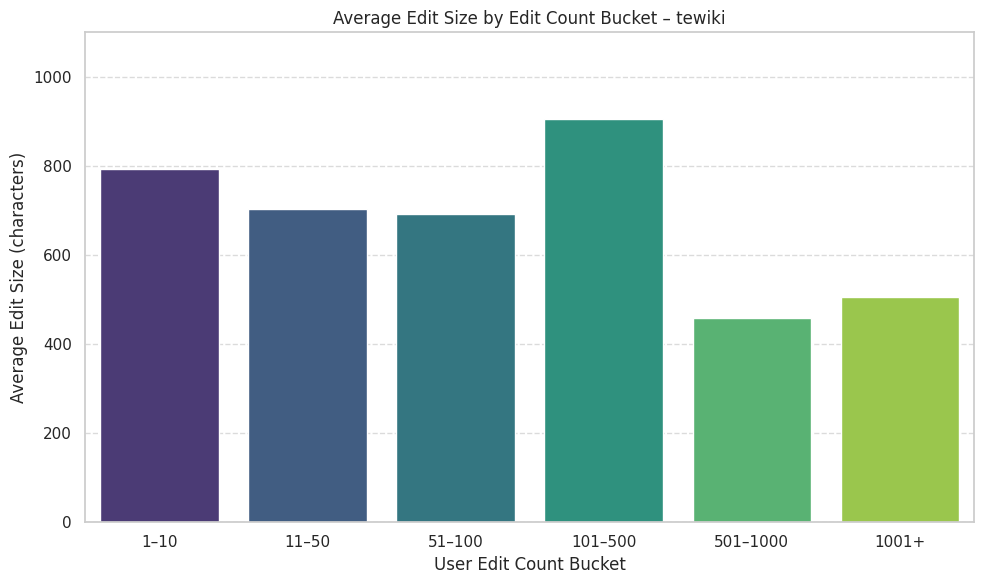

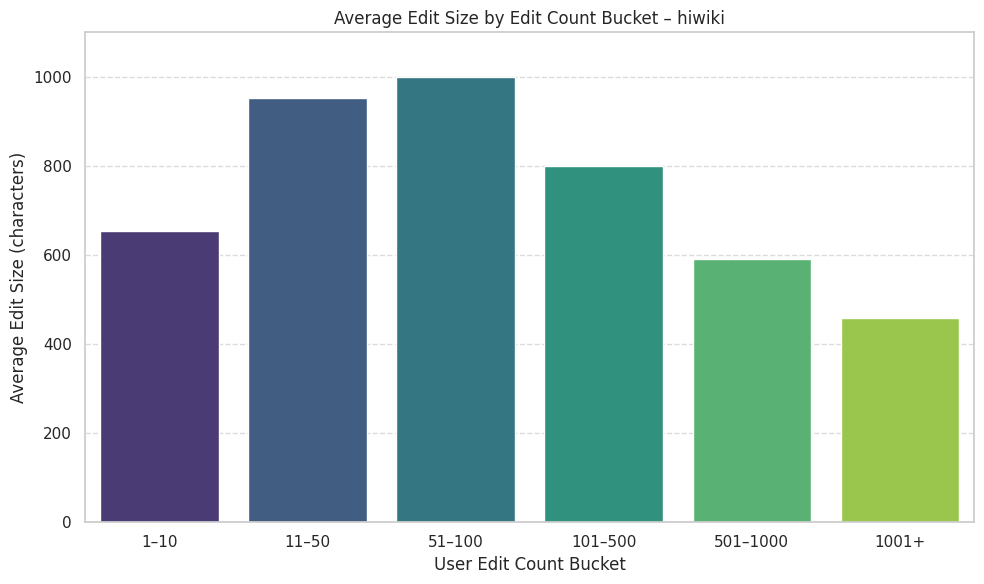

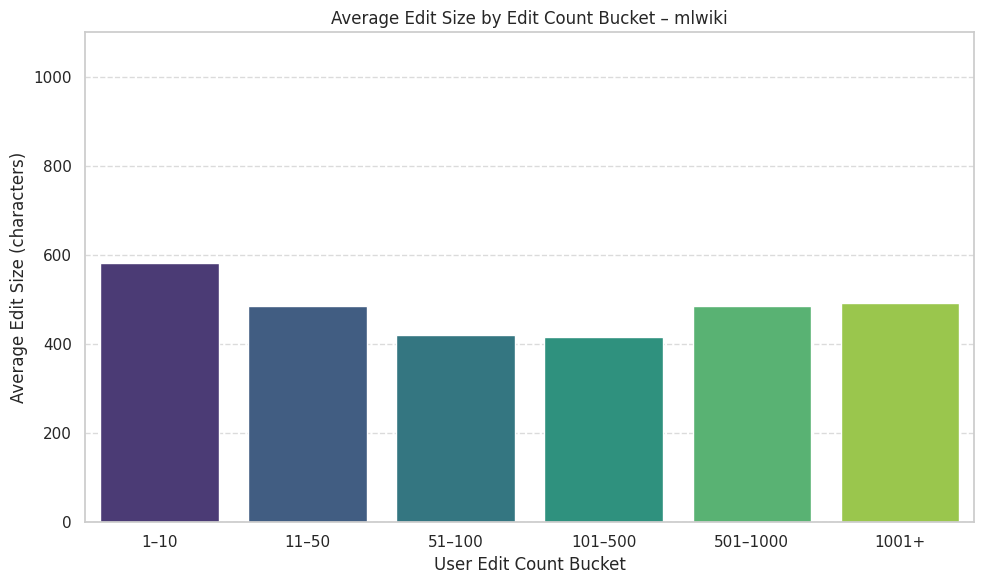

In [50]:
# Run your query and get data
edit_data = get_data(wikis, query1)

#  desired order of edit count buckets
bucket_order = ['1–10', '11–50', '51–100', '101–500', '501–1000', '1001+']


edit_data['edit_count_bucket'] = pd.Categorical(
    edit_data['edit_count_bucket'],
    categories=bucket_order,
    ordered=True
)

# Sort by bucket order
edit_data = edit_data.sort_values(by='edit_count_bucket')

# Set Seaborn style
sns.set(style="whitegrid")

#  Finding  the global max edit size to fix the y-axis across all plots
max_edit_size = edit_data['edit_size'].max()

# Plot for each wiki with consistent y-axis
for wiki in edit_data['wiki'].unique():
    plt.figure(figsize=(10, 6))
    
    wiki_data = edit_data[edit_data['wiki'] == wiki]

    sns.barplot(
        data=wiki_data,
        x='edit_count_bucket',
        y='edit_size',
        palette='viridis'
    )

    # Set consistent y-axis limit across all plots
    plt.ylim(0, float(max_edit_size) * 1.1)  

    plt.title(f'Average Edit Size by Edit Count Bucket – {wiki}')
    plt.xlabel('User Edit Count Bucket')
    plt.ylabel('Average Edit Size (characters)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

<h3>Monthly edits on talk pages </h3>

In [51]:
query_url = "https://raw.githubusercontent.com/Ziyaur-Rahaman/community-insights-dashboard-tooling/refs/heads/branch1/Monthly_edits_on_talk_pages.sql"

query_talk_activity = requests.get(query_url).text

In [52]:
def run_query_for_wikis(wikis, query):
    results = []
    for wiki in wikis:
        output = connect_and_query(wiki, query)
        df = pd.DataFrame(output, columns=["year", "month", "talk_page_type", "edit_count"])
        df['wiki'] = wiki
        results.append(df)
    return pd.concat(results, ignore_index=True),

In [53]:

combined_df = run_query_for_wikis(wikis, query_talk_activity)[0] 


In [54]:
combined_df['year'] = combined_df['year'].astype(int)
combined_df['month'] = combined_df['month'].astype(int)
combined_df['edit_count'] = combined_df['edit_count'].astype(int)
combined_df['date'] = pd.to_datetime(combined_df[['year', 'month']].assign(day=1))

# Determine global min/max for consistent axes
global_x_min = combined_df['date'].min()
global_x_max = combined_df['date'].max()
global_y_max = combined_df.groupby(['wiki', 'date'])['edit_count'].sum().max()

# Custom colors for better visibility
color_map = {
    'Article Talk': '#1f77b4',  # blue
    'User Talk': '#ff7f0e',     # orange
    'Project Talk': '#2ca02c',  # green
}



<Figure size 1600x1200 with 0 Axes>

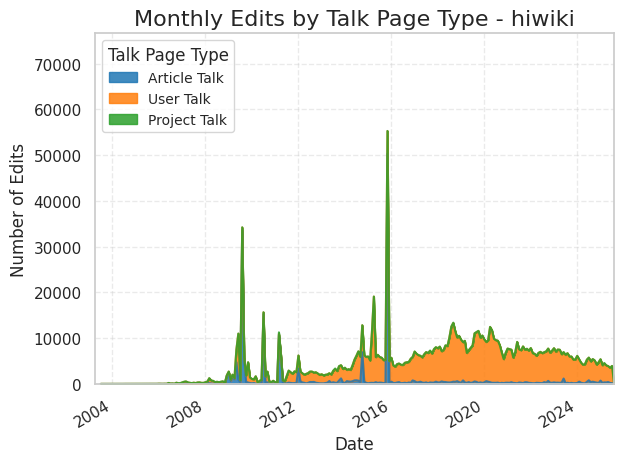

<Figure size 1600x1200 with 0 Axes>

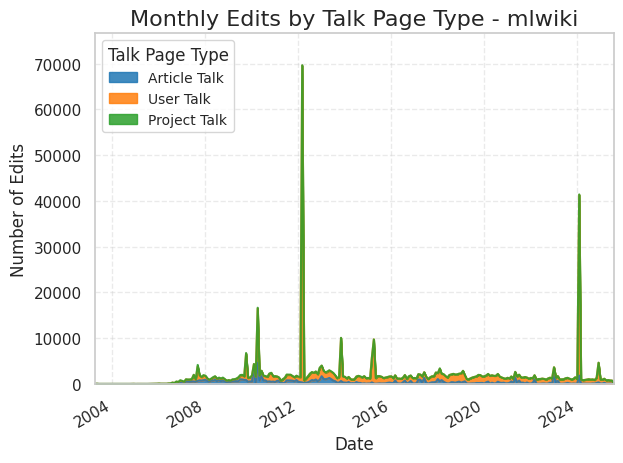

<Figure size 1600x1200 with 0 Axes>

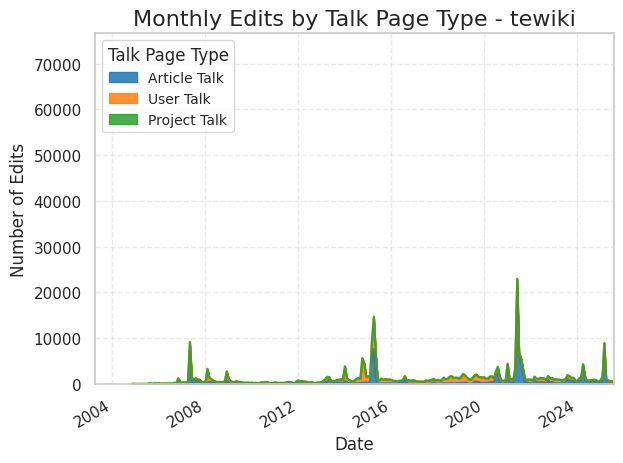

In [84]:
# Plot per wiki
for wiki in combined_df['wiki'].unique():
    temp = combined_df[combined_df['wiki'] == wiki]
    
    pivot_df = temp.pivot(index="date", columns="talk_page_type", values="edit_count").fillna(0)
    pivot_df.sort_index(inplace=True)
    
    # Ensure consistent order and color
    pivot_df = pivot_df.reindex(columns=['Article Talk', 'User Talk', 'Project Talk'], fill_value=0)
    
    # Plot
    plt.figure(figsize=(16, 12))
    pivot_df.plot(
        kind='area',
        stacked=True,
        color=[color_map.get(col, '#cccccc') for col in pivot_df.columns],
        alpha=0.85
    )
    
    plt.title(f"Monthly Edits by Talk Page Type - {wiki}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Number of Edits", fontsize=12)
    plt.xlim(global_x_min, global_x_max)
    plt.ylim(0, global_y_max * 1.1)  # slight padding
    plt.legend(title="Talk Page Type", loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

<h3>number of pages that were never edited after creation</h3>

In [67]:
query_url = "https://raw.githubusercontent.com/Ziyaur-Rahaman/community-insights-dashboard-tooling/refs/heads/branch1/number_of_pages_that_were_never_edited_after_creation.sql"

query = requests.get(query_url).text

In [68]:
def run_page_edit_query(wikis, query):
    results = []
    for wiki in wikis:
        data = connect_and_query(wiki, query)
        count = data[0][0] if data else 0
        results.append({'wiki': wiki, 'no_of_unedited_pages': count})
    return pd.DataFrame(results)


In [69]:
df_unedited = run_page_edit_query(wikis, query)


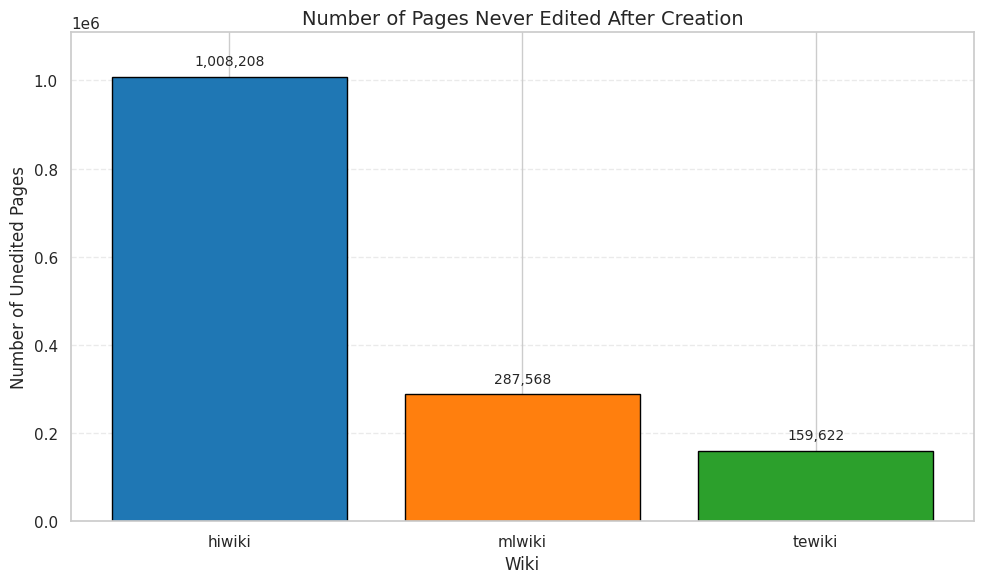

In [86]:

df_unedited['no_of_unedited_pages'] = df_unedited['no_of_unedited_pages'].astype(int)


plt.figure(figsize=(10, 6))

# Plot the bar chart
bars = plt.bar(
    df_unedited['wiki'], 
    df_unedited['no_of_unedited_pages'],
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],
    edgecolor='black'
)

# Titles and labels
plt.title('Number of Pages Never Edited After Creation', fontsize=14)
plt.xlabel('Wiki', fontsize=12)
plt.ylabel('Number of Unedited Pages', fontsize=12)

# Set y-axis limits explicitly
plt.ylim(0, df_unedited['no_of_unedited_pages'].max() * 1.1)

# Show values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 20000, f'{height:,}', 
             ha='center', va='bottom', fontsize=10)

# Final plot tweaks
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()